In [1]:
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm.autonotebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import accuracy_score

from pylib import train_network, set_seed

import os

/tmp/ipykernel_2572122/2310406469.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.backends.cudnn.deterministic=True
set_seed(42)

In [3]:
#This file is bad and will screw up the data loader! 
bad_files = [
    './data/PetImages/Dog/11702.jpg',
    "./data/PetImages/Cat/666.jpg"
]
for f in bad_files:
    if os.path.isfile(f):
        os.remove(f)

In [4]:
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning) 

cat, dog 파일 불러오기

In [5]:
BATCH_SIZE = 64

In [6]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

In [7]:
all_images_cat_and_dog = datasets.ImageFolder(
    "./data/PetImages",
    transform=transforms.Compose([
        transforms.Resize(130),  
        transforms.CenterCrop(128), 
        transforms.ToTensor(), 
    ])
)

train_size = int(len(all_images_cat_and_dog) * 0.8)
test_size = len(all_images_cat_and_dog) - train_size
train_data, test_data = random_split(all_images_cat_and_dog, [train_size, test_size])

catdog_train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
catdog_test_loader = DataLoader(test_data, batch_size=64)

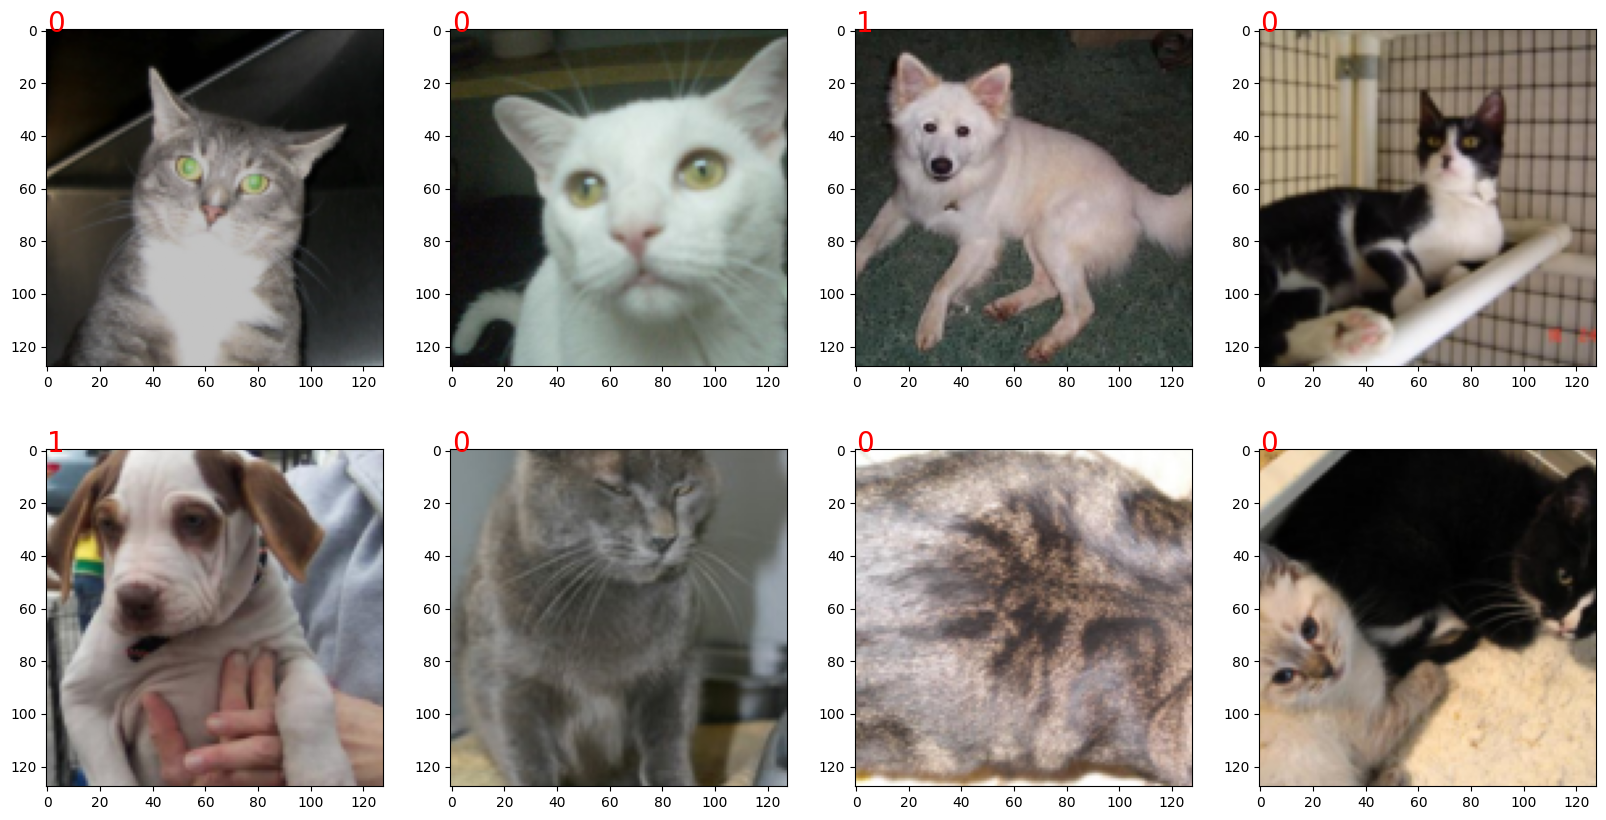

In [8]:
f, axarr = plt.subplots(2,4, figsize=(20,10))
for i in range(2): 
    for j in range(4): 
        x, y = test_data[i*4+j]
        axarr[i,j].imshow(x.numpy().transpose(1,2,0)) 
        axarr[i,j].text(0.0, 0.5, str(round(y,2)), dict(size=20, color='red'))

x_ray_data 불러오기

In [9]:
xray_transform = transforms.Compose([
    transforms.Resize(130),
    transforms.CenterCrop(128),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

xray_train_dataset = torchvision.datasets.ImageFolder("./data/xray_data/train", transform=xray_transform)
xray_test_dataset  = torchvision.datasets.ImageFolder("./data/xray_data/test", transform=xray_transform)

xray_train_loader = DataLoader(xray_train_dataset, batch_size=64, shuffle=True)
xray_test_loader  = DataLoader(xray_test_dataset, batch_size=64)


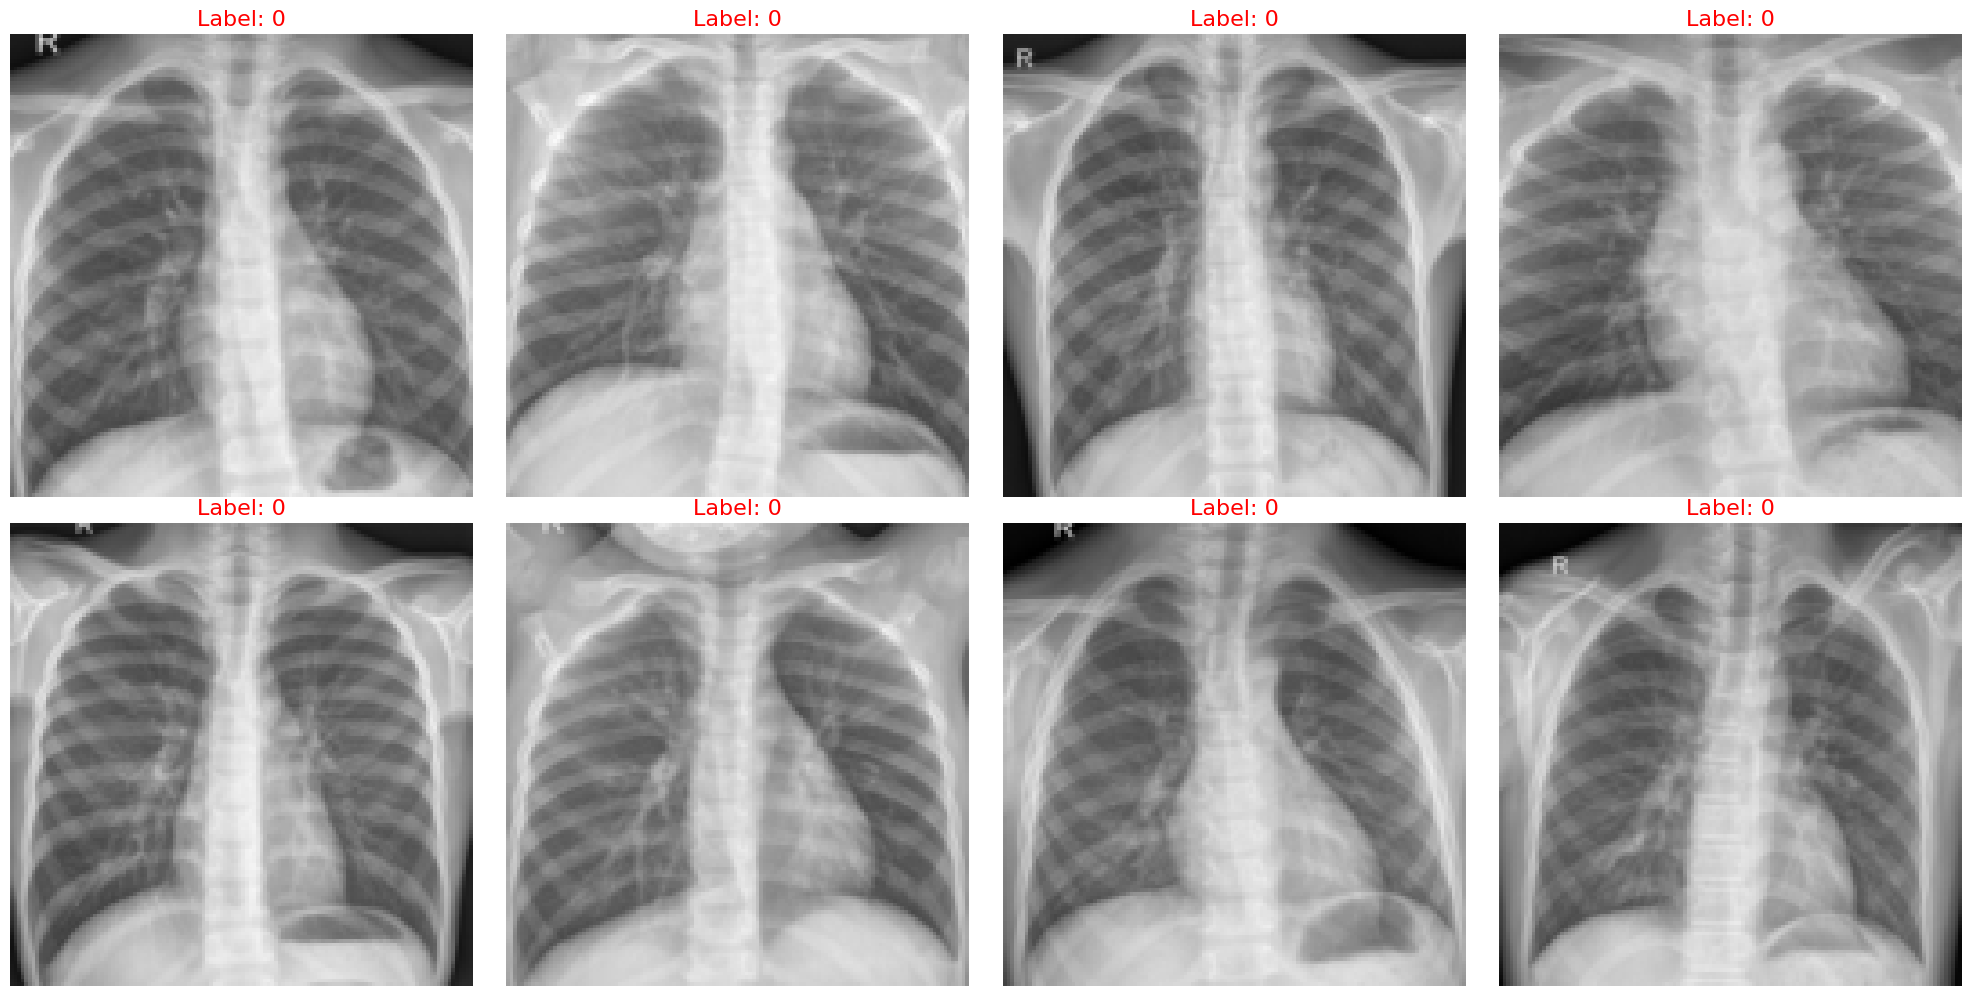

In [10]:
f, axarr = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2): 
    for j in range(4): 
        x, y = xray_test_dataset[i * 4 + j]
        x = x.permute(1, 2, 0)  # [C, H, W] → [H, W, C]
        if x.shape[2] == 1:  # 흑백일 경우
            axarr[i, j].imshow(x.squeeze(-1), cmap='gray')
        else:  # RGB일 경우
            axarr[i, j].imshow(x)
        axarr[i, j].set_title(f"Label: {y}", fontsize=16, color='red')
        axarr[i, j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [12]:
class XrayCNN(nn.Module):
    def __init__(self):
        super(XrayCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [13]:
def get_transfer_model(base='vgg16', freeze_level='unfreeze_all', input_channel=3):
    if base == 'resnet18':
        model = models.resnet18(pretrained=True)
        if input_channel == 1:
            model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')
        model.fc = nn.Linear(model.fc.in_features, 2)

        # Freeze strategy for ResNet18
        if freeze_level == 'full':
            for param in model.parameters():
                param.requires_grad = False
            for param in model.fc.parameters():
                param.requires_grad = True

        elif freeze_level == 'freeze_early':  # freeze conv1 + layer1
            for name, child in model.named_children():
                if name in ['conv1', 'bn1', 'layer1']:
                    for param in child.parameters():
                        param.requires_grad = False

        elif freeze_level == 'freeze_half':  # freeze conv1 + layer1 + layer2
            for name, child in model.named_children():
                if name in ['conv1', 'bn1', 'layer1', 'layer2']:
                    for param in child.parameters():
                        param.requires_grad = False

        elif freeze_level == 'unfreeze_all':
            for param in model.parameters():
                param.requires_grad = True

    elif base == 'vgg16':
        model = models.vgg16(pretrained=True)
        if input_channel == 1:
            features = list(model.features)
            first_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)
            nn.init.kaiming_normal_(first_conv.weight, mode='fan_out', nonlinearity='relu')
            features[0] = first_conv
            model.features = nn.Sequential(*features)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

        # Freeze strategy for VGG16
        if freeze_level == 'full':
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier[6].parameters():
                param.requires_grad = True

        elif freeze_level == 'freeze_features':
            for param in model.features.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True

        elif freeze_level == 'freeze_half':
            for param in model.features[:15].parameters():  # 앞부분만 freeze
                param.requires_grad = False
            for param in model.features[15:].parameters():
                param.requires_grad = True
            for param in model.classifier.parameters():
                param.requires_grad = True

        elif freeze_level == 'unfreeze_all':
            for param in model.parameters():
                param.requires_grad = True

    else:
        raise ValueError("지원하지 않는 모델입니다.")

    return model


In [14]:
class NormalizeInput(nn.Module):
    def __init__(self, baseModel, input_channel=3):
        super(NormalizeInput, self).__init__()
        self.baseModel = baseModel
        if input_channel == 3:
            self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1), requires_grad=False)
            self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1), requires_grad=False)
        elif input_channel == 1:
            self.mean = nn.Parameter(torch.tensor([0.5]).view(1,1,1,1), requires_grad=False)
            self.std = nn.Parameter(torch.tensor([0.5]).view(1,1,1,1), requires_grad=False)

    def forward(self, input):
        input = (input - self.mean) / self.std
        return self.baseModel(input)


In [15]:
def train_model(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    acc_list = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 평가
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch)
                predicted = torch.argmax(pred, dim=1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        acc = correct / total
        acc_list.append(acc)

        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            print(f"  [Epoch {epoch+1:>2}] Loss: {epoch_loss:.4f} | Accuracy: {acc:.4f}")

    return acc_list


In [16]:
import copy
import torch

def run_all_experiments(dataset_name, train_loader, test_loader, input_channel, device):
    results = {}
    best_acc = 0.0
    best_model_wts = None
    best_model_label = ""

    # Custom CNN
    if dataset_name == "CatDog":
        model = CatDogCNN()
    elif dataset_name == "Xray":
        model = XrayCNN()
    else:
        raise ValueError("dataset_name은 'CatDog' 또는 'Xray'만 가능합니다.")

    print(f"▶ Training CustomCNN for {dataset_name}...")
    acc_list = train_model(model, train_loader, test_loader, device)
    results[f'{dataset_name}_CustomCNN'] = acc_list
    final_acc = acc_list[-1]
    print(f"  ⤷ Final Accuracy: {final_acc:.4f}")

    if final_acc > best_acc:
        best_acc = final_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_model_label = f'{dataset_name}_CustomCNN'

    # Freeze 설정
    freeze_levels_resnet = ['full', 'freeze_early', 'freeze_half', 'unfreeze_all']
    freeze_levels_vgg = ['full', 'freeze_features', 'freeze_half', 'unfreeze_all']

    for base_model in ['resnet18', 'vgg16']:
        freeze_levels = freeze_levels_resnet if base_model == 'resnet18' else freeze_levels_vgg

        for freeze_type in freeze_levels:
            print(f"▶ Training {base_model.upper()} ({freeze_type}) for {dataset_name}...")
            model = get_transfer_model(
                base=base_model,
                freeze_level=freeze_type,
                input_channel=input_channel
            )
            model = NormalizeInput(model, input_channel=input_channel)
            label = f'{dataset_name}_{base_model}_{freeze_type}'
            acc_list = train_model(model, train_loader, test_loader, device)
            results[label] = acc_list
            final_acc = acc_list[-1]
            print(f"  ⤷ Final Accuracy: {final_acc:.4f}")

            if final_acc > best_acc:
                best_acc = final_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_model_label = label

    # 모델 저장
    if best_model_wts is not None:
        torch.save(best_model_wts, f"{dataset_name}_best_model.pt")
        print(f"\n✅ Best model saved as '{dataset_name}_best_model.pt' (Model: {best_model_label}, Accuracy: {best_acc:.4f})")

    return results


In [17]:
def plot_accuracies(result_dict):
    plt.figure(figsize=(12, 6))
    for label, acc_list in result_dict.items():
        plt.plot(acc_list, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
xray_results = run_all_experiments(
    dataset_name="Xray",
    train_loader=xray_train_loader,
    test_loader=xray_test_loader,
    input_channel=3,
    device=device
)

▶ Training CustomCNN for Xray...
  [Epoch  2] Loss: 7.0000 | Accuracy: 0.8205
  [Epoch  4] Loss: 4.9141 | Accuracy: 0.8029
  [Epoch  6] Loss: 2.6545 | Accuracy: 0.7676
  [Epoch  8] Loss: 1.2781 | Accuracy: 0.6955
  [Epoch 10] Loss: 3.9439 | Accuracy: 0.8205
  ⤷ Final Accuracy: 0.8205
▶ Training RESNET18 (full) for Xray...


/home/hadoop/anaconda3/envs/wookoo/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hadoop/anaconda3/envs/wookoo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  [Epoch  2] Loss: 13.4220 | Accuracy: 0.7885
  [Epoch  4] Loss: 10.5482 | Accuracy: 0.7708
  [Epoch  6] Loss: 9.9828 | Accuracy: 0.7933
  [Epoch  8] Loss: 9.6707 | Accuracy: 0.8045
  [Epoch 10] Loss: 9.2174 | Accuracy: 0.7612
  ⤷ Final Accuracy: 0.7612
▶ Training RESNET18 (freeze_early) for Xray...
  [Epoch  2] Loss: 2.6981 | Accuracy: 0.7724
  [Epoch  4] Loss: 1.5572 | Accuracy: 0.7147
  [Epoch  6] Loss: 1.2527 | Accuracy: 0.8189
  [Epoch  8] Loss: 0.2944 | Accuracy: 0.8478
  [Epoch 10] Loss: 0.9284 | Accuracy: 0.8686
  ⤷ Final Accuracy: 0.8686
▶ Training RESNET18 (freeze_half) for Xray...
  [Epoch  2] Loss: 2.1194 | Accuracy: 0.7821
  [Epoch  4] Loss: 1.4930 | Accuracy: 0.8301
  [Epoch  6] Loss: 1.1383 | Accuracy: 0.7949
  [Epoch  8] Loss: 0.6154 | Accuracy: 0.8686
  [Epoch 10] Loss: 0.8797 | Accuracy: 0.8093
  ⤷ Final Accuracy: 0.8093
▶ Training RESNET18 (unfreeze_all) for Xray...
  [Epoch  2] Loss: 4.1698 | Accuracy: 0.7724
  [Epoch  4] Loss: 2.1944 | Accuracy: 0.8013
  [Epoch  6]

/home/hadoop/anaconda3/envs/wookoo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  [Epoch  2] Loss: 16.5484 | Accuracy: 0.8253
  [Epoch  4] Loss: 14.3328 | Accuracy: 0.8125
  [Epoch  6] Loss: 14.6010 | Accuracy: 0.7708
  [Epoch  8] Loss: 14.1255 | Accuracy: 0.7708
  [Epoch 10] Loss: 15.0077 | Accuracy: 0.7532
  ⤷ Final Accuracy: 0.7532
▶ Training VGG16 (freeze_features) for Xray...
  [Epoch  2] Loss: 15.3314 | Accuracy: 0.8478
  [Epoch  4] Loss: 16.3947 | Accuracy: 0.7292
  [Epoch  6] Loss: 12.3927 | Accuracy: 0.7404
  [Epoch  8] Loss: 12.1690 | Accuracy: 0.8301
  [Epoch 10] Loss: 7.6467 | Accuracy: 0.7997
  ⤷ Final Accuracy: 0.7997
▶ Training VGG16 (freeze_half) for Xray...
  [Epoch  2] Loss: 47.0032 | Accuracy: 0.6250
  [Epoch  4] Loss: 46.9103 | Accuracy: 0.6250
  [Epoch  6] Loss: 46.9323 | Accuracy: 0.6250
  [Epoch  8] Loss: 47.0004 | Accuracy: 0.6250
  [Epoch 10] Loss: 46.9095 | Accuracy: 0.6250
  ⤷ Final Accuracy: 0.6250
▶ Training VGG16 (unfreeze_all) for Xray...
  [Epoch  2] Loss: 45.5960 | Accuracy: 0.6250
  [Epoch  4] Loss: 12.2001 | Accuracy: 0.7853
  [E

In [19]:
catdog_results = run_all_experiments(
    dataset_name="CatDog",
    train_loader=catdog_train_loader,
    test_loader=catdog_test_loader,
    input_channel=3,  # RGB
    device=device
)

▶ Training CustomCNN for CatDog...


/home/hadoop/anaconda3/envs/wookoo/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  [Epoch  2] Loss: 177.0025 | Accuracy: 0.7324
  [Epoch  4] Loss: 133.7871 | Accuracy: 0.7698
  [Epoch  6] Loss: 89.5899 | Accuracy: 0.7638
  [Epoch  8] Loss: 33.1151 | Accuracy: 0.7492
  [Epoch 10] Loss: 8.0781 | Accuracy: 0.7586
  ⤷ Final Accuracy: 0.7586
▶ Training RESNET18 (full) for CatDog...
  [Epoch  2] Loss: 52.2425 | Accuracy: 0.9378
  [Epoch  4] Loss: 50.2946 | Accuracy: 0.9382
  [Epoch  6] Loss: 47.3312 | Accuracy: 0.9408
  [Epoch  8] Loss: 46.8324 | Accuracy: 0.9398
  [Epoch 10] Loss: 46.9638 | Accuracy: 0.9402
  ⤷ Final Accuracy: 0.9402
▶ Training RESNET18 (freeze_early) for CatDog...
  [Epoch  2] Loss: 23.3382 | Accuracy: 0.9600
  [Epoch  4] Loss: 11.5151 | Accuracy: 0.9612
  [Epoch  6] Loss: 8.3242 | Accuracy: 0.9620
  [Epoch  8] Loss: 5.9494 | Accuracy: 0.9634
  [Epoch 10] Loss: 4.7380 | Accuracy: 0.9642
  ⤷ Final Accuracy: 0.9642
▶ Training RESNET18 (freeze_half) for CatDog...
  [Epoch  2] Loss: 19.2970 | Accuracy: 0.9644
  [Epoch  4] Loss: 9.2795 | Accuracy: 0.9658
  

In [20]:
catdog_transform_augmented = transforms.Compose([
    transforms.Resize(130),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(p=0.5),       # 좌우 반전
    transforms.RandomRotation(degrees=15),        # ±15도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

all_images_cat_and_dog_aug = datasets.ImageFolder(
    "./data/PetImages", transform=catdog_transform_augmented
)

train_size = int(len(all_images_cat_and_dog_aug) * 0.8)
test_size = len(all_images_cat_and_dog_aug) - train_size
train_data_aug, test_data_aug = random_split(all_images_cat_and_dog_aug, [train_size, test_size])

catdog_train_loader_aug = DataLoader(train_data_aug, batch_size=64, shuffle=True)
catdog_test_loader_aug = DataLoader(test_data_aug, batch_size=64)


In [21]:
xray_transform_augmented = transforms.Compose([
    transforms.Resize(130),
    transforms.CenterCrop(128),
    transforms.RandomRotation(10),                          # ±10도 회전
    transforms.RandomHorizontalFlip(p=0.5),                 # 좌우 반전
    transforms.Grayscale(num_output_channels=3),            # 1채널 → 3채널
    transforms.ToTensor()
])

xray_train_dataset_aug = datasets.ImageFolder("./data/xray_data/train", transform=xray_transform_augmented)
xray_test_dataset_aug  = datasets.ImageFolder("./data/xray_data/test", transform=xray_transform)  # 테스트는 증강 X

xray_train_loader_aug = DataLoader(xray_train_dataset_aug, batch_size=64, shuffle=True)
xray_test_loader_aug  = DataLoader(xray_test_dataset_aug, batch_size=64)


In [ ]:
import copy
import torch

def run_resnet_experiments(dataset_name, train_loader, test_loader, input_channel, device):
    results = {}
    best_acc = 0.0
    best_model_wts = None
    best_model_label = ""

    # Custom CNN
    if dataset_name == "CatDog":
        model = CatDogCNN()
    elif dataset_name == "Xray":
        model = XrayCNN()

    print(f"▶ Training CustomCNN for {dataset_name}...")
    acc_list = train_model(model, train_loader, test_loader, device)
    results[f'{dataset_name}_CustomCNN'] = acc_list
    final_acc = acc_list[-1]
    print(f"  ⤷ Final Accuracy: {final_acc:.4f}")

    if final_acc > best_acc:
        best_acc = final_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_model_label = f'{dataset_name}_CustomCNN'

    # ResNet18만 실험
    freeze_levels = ['full', 'freeze_early', 'freeze_half', 'unfreeze_all']
    for freeze_type in freeze_levels:
        print(f"▶ Training ResNet18 ({freeze_type}) for {dataset_name}...")
        model = get_transfer_model(
            base='resnet18',
            freeze_level=freeze_type,
            input_channel=input_channel
        )
        model = NormalizeInput(model, input_channel=input_channel)
        label = f'{dataset_name}_resnet18_{freeze_type}'
        acc_list = train_model(model, train_loader, test_loader, device)
        results[label] = acc_list
        final_acc = acc_list[-1]
        print(f"  ⤷ Final Accuracy: {final_acc:.4f}")

        if final_acc > best_acc:
            best_acc = final_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_label = label

    # Best 모델 저장
    if best_model_wts is not None:
        torch.save(best_model_wts, f"{dataset_name}_best_resnet_model.pt")
        print(f"\n✅ Best ResNet18 model saved as '{dataset_name}_best_resnet_model.pt' (Model: {best_model_label}, Accuracy: {best_acc:.4f})") 

    return results
